# Minimal example - Pytorch API

## Define nn.Module with feature extractor network

Notes:
* In the forward funcition one must define the `self.feature_maps = [some_tensor, another_tensor]` parameter. This parameter is used by the `PytorchReceptiveField` to get the desired feature map. The feature map tensor is of shape [batch_size, num_channels, width, height]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn

class Linear(nn.Module):
    """An identity activation function"""
    def forward(self, x):
        return x
    

class SimpleVGG(nn.Module):
    def __init__(self, disable_activations: bool = False):
        super(SimpleVGG, self).__init__()
        self.features = self._make_layers(disable_activations)

    def forward(self, x):
        # index of layers with feature maps
        select = [8, 13]
        # this is required for pytorch, a paramter with this name is 
        # used as a final feature map
        self.feature_maps = []
        for l, layer in enumerate(self.features):
            x = layer(x)
            if l in select:
                self.feature_maps.append(x)
        return x

    def _make_layers(self, disable_activations: bool):
        activation = lambda: Linear() if disable_activations else nn.ReLU()
        layers = [
            nn.Conv2d(3, 64, kernel_size=3),
            activation(),
            nn.Conv2d(64, 64, kernel_size=3),
            activation(),
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            activation(),
            nn.Conv2d(128, 128, kernel_size=3),
            activation(), # 8
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            activation(),
            nn.Conv2d(256, 256, kernel_size=3),
            activation(), # 13
        ]        
        return nn.Sequential(*layers)    

## Define model build function
Notes:
* In case when using layers which depends behave differently on training and eval mode it is recommended to set model to eval mode: `model.eval()`

In [3]:
def model_fn() -> nn.Module:
    model = SimpleVGG(disable_activations=True)
    model.eval()
    return model

## Run RF estimation

In [5]:
from receptivefield.pytorch import PytorchReceptiveField

input_shape = [128, 128, 3]

rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape)
rf_params

[2018-07-21 08:57:52,781][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=58, h=58, c=128), GridShape(n=1, w=25, h=25, c=256)]
[2018-07-21 08:57:52,782][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=128, h=128, c=3)
[2018-07-21 08:57:53,774][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=14, h=14))
[2018-07-21 08:57:53,775][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=32, h=32))


[FeatureMapDescription(size=Size(w=58, h=58), rf=ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=14, h=14))),
 FeatureMapDescription(size=Size(w=25, h=25), rf=ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=32, h=32)))]

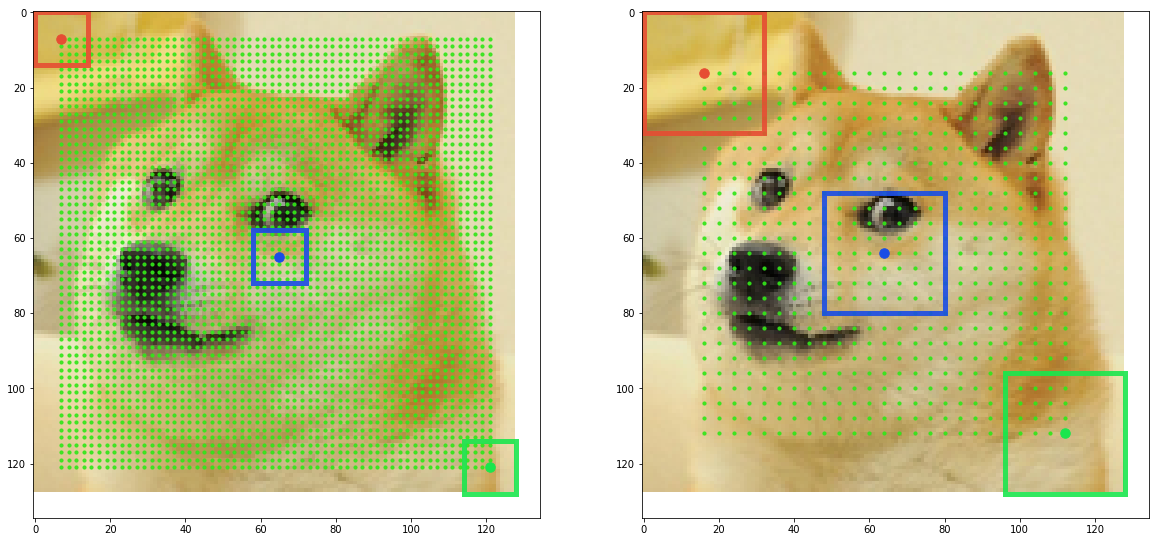

In [6]:
from receptivefield.image import get_default_image
rf.plot_rf_grids(get_default_image(input_shape, name='doge'), figsize=(20, 12), layout=(1, 2))

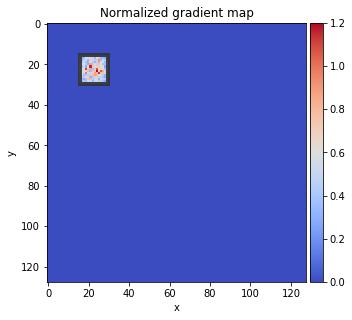

In [7]:
rf.plot_gradient_at(fm_id=0, point=(8, 8))